<a href="https://colab.research.google.com/github/JoseGallardoArb/UsefullApplications/blob/main/PBIForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyección del PBI


---
Autor: José Diego Gallardo Arbildo

Comentarios y observaciones a: jose.gallardoa@pucp.pe

El presente código tiene por objetivo realizar proyecciones del PBI en base a una estructura ARMA para esta variable y apoyandose con la proyección de los 10 mejores predictores del PBI identificados por F. Perez (2018).

## Carga y Visualización de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#import seaborn as sns #para elaboración de graficos mapas de calor
#sns.reset_orig
#mpl.rcParams.update(mpl.rcParamsDefault) #Resetea matplotlib para graficos no compatibles para seaborn [Reiniciar entorno de ejecución]

url = "https://raw.githubusercontent.com/JoseGallardoArb/Data/main/PBIForecastData.csv" 
df = pd.read_csv(url)
df['DATE']=pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df.head()

,PBI,PELEC,CINTC,VOLINPUT,INDPRO,INGRESO,CREDMN,IGBVL
DATE,,,,,,,,
2004-01-01,3.674966,4.229032,6.868890,-16.532481,1.37359,-1.077056,13.514563,79.913009
2004-02-01,4.245959,7.350977,6.468289,9.215095,1.84294,1.173879,9.453369,76.578574
2004-03-01,5.774257,5.436382,7.780494,-2.812554,1.57144,2.601558,8.226966,94.734749
2004-04-01,4.247995,6.194900,2.201965,7.594470,2.76450,3.193371,5.003304,59.889402
2004-05-01,3.950757,6.124446,2.770659,19.005229,3.55004,0.972555,4.772573,61.851754


Text(0.5, 1.0, 'Indice General Bolsa de Valores de Lima')

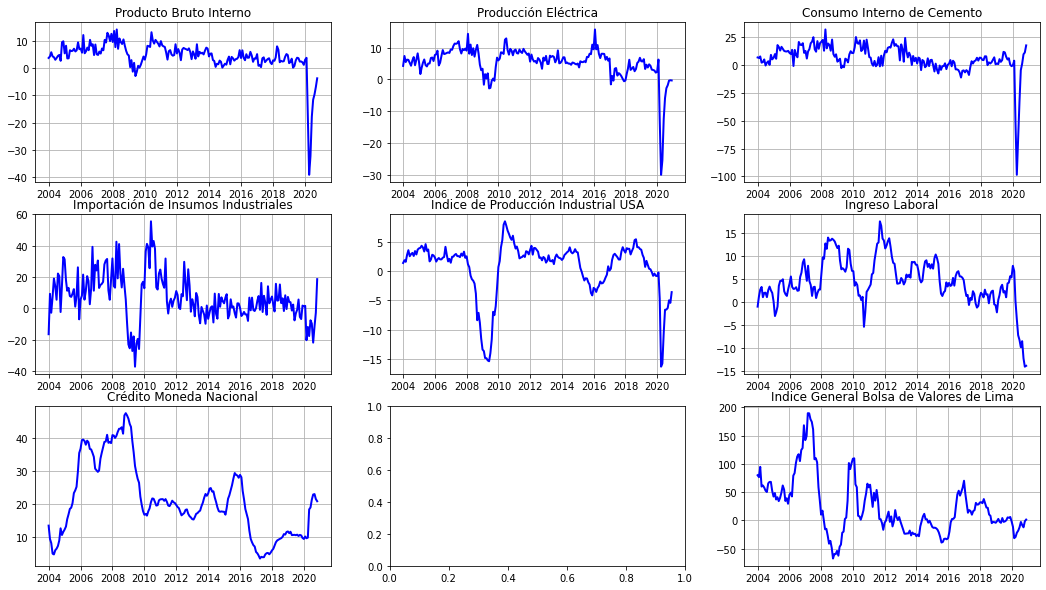

In [2]:
fig, axs = plt.subplots(3, 3,figsize=(18, 10))
axs[0, 0].plot(df["PBI"],color='b',linewidth=2.0)
axs[0, 0].grid(which='major')
axs[0, 0].set_title("Producto Bruto Interno")
axs[0, 1].plot(df["PELEC"],color='b',linewidth=2.0)
axs[0, 1].grid(which='major')
axs[0, 1].set_title('Producción Eléctrica')
axs[0, 2].plot(df["CINTC"],color='b',linewidth=2.0)
axs[0, 2].grid(which='major')
axs[0, 2].set_title('Consumo Interno de Cemento')
axs[1, 0].plot(df["VOLINPUT"],color='b',linewidth=2.0)
axs[1, 0].grid(which='major')
axs[1, 0].set_title("Importación de Insumos Industriales")
axs[1, 1].plot(df["INDPRO"],color='b',linewidth=2.0)
axs[1, 1].grid(which='major')
axs[1, 1].set_title("Indice de Producción Industrial USA")
axs[1, 2].plot(df["INGRESO"],color='b',linewidth=2.0)
axs[1, 2].grid(which='major')
axs[1, 2].set_title("Ingreso Laboral")
axs[2, 0].plot(df["CREDMN"],color='b',linewidth=2.0)
axs[2, 0].grid(which='major')
axs[2, 0].set_title("Crédito Moneda Nacional")
axs[2, 2].plot(df["IGBVL"],color='b',linewidth=2.0)
axs[2, 2].grid(which='major')
axs[2, 2].set_title("Indice General Bolsa de Valores de Lima")


## Selección de orden ARMA

Primeramente se revisa la disposición de datos

In [3]:
df.tail()

,PBI,PELEC,CINTC,VOLINPUT,INDPRO,INGRESO,CREDMN,IGBVL
DATE,,,,,,,,
2020-09-01,-6.945,-1.852153,9.73,-11.497408,-6.28076,-12.305923,23.080085,-8.437252
2020-10-01,-3.790,-0.399158,11.32,-2.836825,-4.97235,-14.108501,21.581743,-12.221481
2020-11-01,NaN,-0.281037,17.72,18.628586,-5.40773,-13.921101,20.914876,-1.401982
2020-12-01,NaN,-0.349109,NaN,NaN,-3.58249,NaN,NaN,1.442162
2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se generan variables guía

In [4]:
armax  = 4                   # Orden AR maximo a testear
mamax  = 2                   # Orden MA maximo a testear
criteria  = "aic"            # Criterio de elección
start_date  = '2004-01-01'   # Fecha inicial
end_PBI     = '2020-10-01'   # Fecha final de datos PBI
end_PBI_L1  = '2020-11-01'   # Fecha final de datos PBI + 1: CINTC, VOLINPUT, INGRESO, CREDMN
end_PBI_L2  = '2020-12-01'   # Fecha final de datos PBI + 2: PELEC, INDPRO, IGBVL
num_steps   =  14            # Periodos a proyectar despues de la ultima observación del PBI
start_datef = '2020-11-01'   # Fecha inicial proyeccion end_pbi + 1
end_datef   = '2021-12-01'   # Fecha final proyeccion end_PBI + num_steps

Se escogen los mejores modelos ARMA para las variables

In [5]:
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

lagresults = pd.DataFrame(columns=df.columns,index=range(0,1))

for c in df.columns:
  order_selection = arma_order_select_ic(df[start_date:end_PBI][c], max_ar = armax, max_ma = mamax, ic = criteria)
  lagresults[c][0] = str(order_selection.aic_min_order) #REQUIERE CAMBIO dependiente del criterio

lagresults

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,PBI,PELEC,CINTC,VOLINPUT,INDPRO,INGRESO,CREDMN,IGBVL
0,"(3, 2)","(3, 2)","(2, 1)","(3, 2)","(2, 2)","(4, 2)","(4, 2)","(3, 2)"


## Predicción de las variables auxiliares

Text(0.5, 1.0, 'Predicción IGBVL')

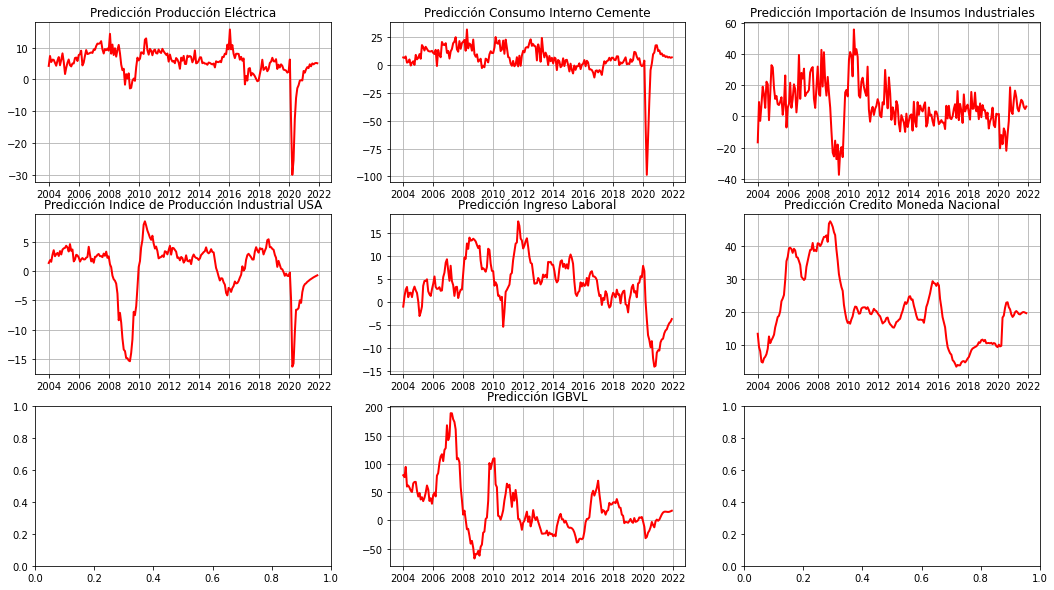

In [6]:
import statsmodels.api as sm

# Variables con END_L1
#-------------------------------------------------------------------------------
# Consumo Interno de Cemento - CINTC
cintcmod = sm.tsa.statespace.SARIMAX(df[start_date:end_PBI_L1]["CINTC"],order=(2, 0, 1),trend='c')
results_cintc = cintcmod.fit()
pred_cintc = results_cintc.get_forecast(steps=num_steps-1)
cintc_f = pd.concat([df[start_date:end_PBI_L1]["CINTC"],pred_cintc.predicted_mean])

# Volumen de Insumos Industriales - VOLINPUT
volinputmod = sm.tsa.statespace.SARIMAX(df[start_date:end_PBI_L1]["VOLINPUT"],order=(3, 0, 2),trend='c')
results_volinput = volinputmod.fit()
pred_volinput = results_volinput.get_forecast(steps=num_steps-1)
volinput_f = pd.concat([df[start_date:end_PBI_L1]["VOLINPUT"],pred_volinput.predicted_mean])

# Indice Laboral - INGRESO
ingresomod = sm.tsa.statespace.SARIMAX(df[start_date:end_PBI_L1]["INGRESO"],order=(4, 0, 2),trend='c')
results_ingreso = ingresomod.fit()
pred_ingreso = results_ingreso.get_forecast(steps=num_steps-1)
ingreso_f = pd.concat([df[start_date:end_PBI_L1]["INGRESO"],pred_ingreso.predicted_mean])

# Credito Moneda Nacional - CREDMN
credmnmod = sm.tsa.statespace.SARIMAX(df[start_date:end_PBI_L1]["CREDMN"], order=(4, 0, 2),trend='c')
results_credmn = credmnmod.fit()
pred_credmn = results_credmn.get_forecast(steps=num_steps-1)
credmn_f = pd.concat([df[start_date:end_PBI_L1]["CREDMN"],pred_credmn.predicted_mean])


# Variables con END_L2
#-------------------------------------------------------------------------------
# Predicción Producción Electrica - PELEC
pelecmod = sm.tsa.statespace.SARIMAX(df[start_date:end_PBI_L2]["PELEC"],order=(3, 0, 2),trend='c')
results_pelec = pelecmod.fit()
pred_pelec = results_pelec.get_forecast(steps=num_steps-2)
pelec_f = pd.concat([df[start_date:end_PBI_L2]["PELEC"],pred_pelec.predicted_mean])

# Indice de producción industrial - INDPRO
indpromod = sm.tsa.statespace.SARIMAX(df[start_date:end_PBI_L2]["INDPRO"],order=(2, 0, 2),trend='c')
results_indpro = indpromod.fit()
pred_indpro = results_indpro.get_forecast(steps=num_steps-2)
indpro_f = pd.concat([df[start_date:end_PBI_L2]["INDPRO"],pred_indpro.predicted_mean])

# Indice General Bolsa de Valores de Lima - IGBVL
igbvlmod = sm.tsa.statespace.SARIMAX(df[start_date:end_PBI_L2]["IGBVL"],order=(3, 0, 2),trend='c')
results_igbvl = igbvlmod.fit()
pred_igbvl = results_igbvl.get_forecast(steps=num_steps-2)
igbvl_f = pd.concat([df[start_date:end_PBI_L2]["IGBVL"],pred_igbvl.predicted_mean])


# Graficando los resultados
#-------------------------------------------------------------------------------
fig, axs = plt.subplots(3, 3,figsize=(18, 10))
axs[0, 0].plot(pelec_f,color='r',linewidth=2.0)
axs[0, 0].grid(which='major')
axs[0, 0].set_title("Predicción Producción Eléctrica")
axs[0, 1].grid(which='major')
axs[0, 1].plot(cintc_f,color='r',linewidth=2.0)
axs[0, 1].set_title("Predicción Consumo Interno Cemente")
axs[0, 2].plot(volinput_f,color='r',linewidth=2.0)
axs[0, 2].grid(which='major')
axs[0, 2].set_title("Predicción Importación de Insumos Industriales")
axs[1, 0].plot(indpro_f,color='r',linewidth=2.0)
axs[1, 0].grid(which='major')
axs[1, 0].set_title("Predicción Indice de Producción Industrial USA")
axs[1, 1].plot(ingreso_f,color='r',linewidth=2.0)
axs[1, 1].grid(which='major')
axs[1, 1].set_title("Predicción Ingreso Laboral")
axs[1, 2].plot(credmn_f,color='r',linewidth=2.0)
axs[1, 2].grid(which='major')
axs[1, 2].set_title("Predicción Credito Moneda Nacional")
axs[2, 1].plot(igbvl_f,color='r',linewidth=2.0)
axs[2, 1].grid(which='major')
axs[2, 1].set_title("Predicción IGBVL")

## Predicción del PBI

In [7]:
# Definiendo las variables exógenas
exo = pd.concat([pelec_f,cintc_f,volinput_f,pelec_f.shift(),cintc_f.shift(),indpro_f,ingreso_f.shift(),volinput_f.shift(),credmn_f,igbvl_f.shift()],axis=1).dropna()
# Generando el training sample
start_date_exo = '2004-02-01'
pbimod = sm.tsa.SARIMAX(df[start_date_exo:end_PBI]["PBI"], order=(3, 0, 2), exog=exo[start_date_exo:end_PBI],trend='c') #ARMA(2,1) [Menos cercano] vs ARMA(3,2)[Posible overfitting]
# Generando predicción
results_pbi = pbimod.fit()
pred_pbi = results_pbi.get_forecast(steps=num_steps,exog=exo[start_datef:end_datef])
# Obteniendo la serie final
pbi_f = pd.concat([df[start_datef:end_datef]["PBI"],pred_pbi.predicted_mean])

## Grafico de la proyección


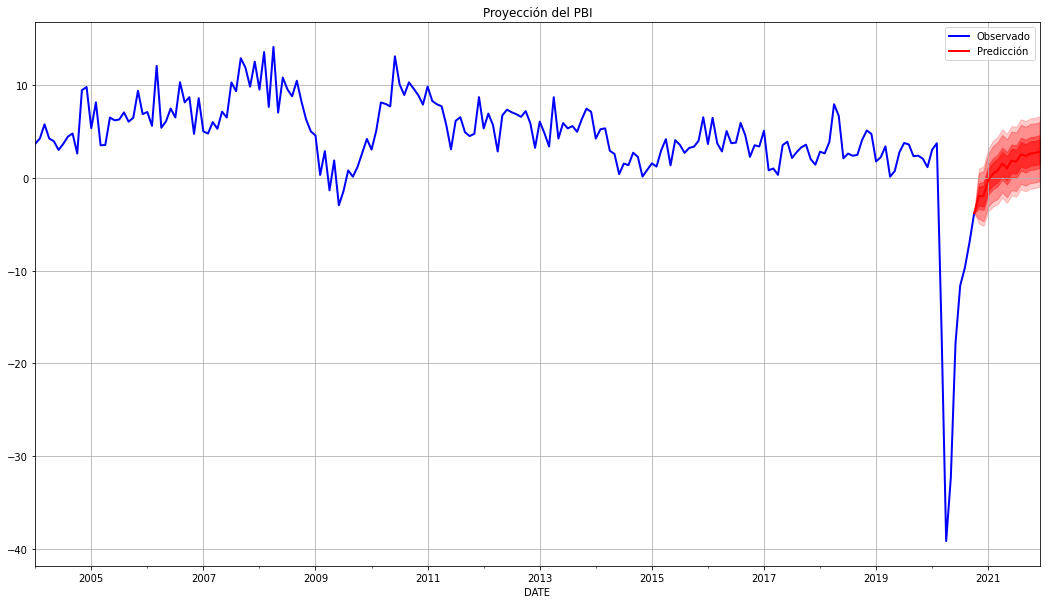

In [8]:
# Variable auxiliar
line = pd.to_datetime(end_PBI, format="%Y-%m-%d")
new_row = pd.DataFrame([-3.790],columns=[0],index=[line])

# Generando punto inicial de la media de la proyección
pbif_mean = pred_pbi.predicted_mean
n_pbifmean = pd.concat([pd.DataFrame(new_row),pbif_mean])


# Generando puntos iniciales para los intervalos de confiaza
new_row = pd.DataFrame([[-3.790,-3.790]],columns=['lower PBI', 'upper PBI'],index=[line]) # Variable auxiliar

# Intervalo 95
pred_ci95 = pred_pbi.conf_int() # Default 95%
n_pred_ci95 = pd.concat([pd.DataFrame(new_row),pred_ci95])

# Intervalo 90
pred_ci90 = pred_pbi.conf_int(alpha = .10) 
n_pred_ci90 = pd.concat([pd.DataFrame(new_row),pred_ci90])

# Intervalo 68
pred_ci68 = pred_pbi.conf_int(alpha = .36) 
n_pred_ci68 = pd.concat([pd.DataFrame(new_row),pred_ci68])

# Intervalo 50
pred_ci50 = pred_pbi.conf_int(alpha = .50) 
n_pred_ci50 = pd.concat([pd.DataFrame(new_row),pred_ci50])

# Graficando la proyección
ax = df["PBI"].plot(figsize=(18, 10),color='b',linewidth=2.0)
n_pbifmean.plot(ax=ax,color='r',linewidth=2.0)
ax.fill_between(n_pred_ci95.index,
                n_pred_ci95.iloc[:, 0],
                n_pred_ci95.iloc[:, 1], color='r', alpha=.20)
ax.fill_between(n_pred_ci90.index,
                n_pred_ci90.iloc[:, 0],
                n_pred_ci90.iloc[:, 1], color='r', alpha=.30)
ax.fill_between(n_pred_ci68.index,
                n_pred_ci68.iloc[:, 0],
                n_pred_ci68.iloc[:, 1], color='r', alpha=.40)
ax.fill_between(n_pred_ci50.index,
                n_pred_ci50.iloc[:, 0],
                n_pred_ci50.iloc[:, 1], color='r', alpha=.50)

plt.legend(['Observado', 'Predicción'])
plt.title('Proyección del PBI')
plt.grid("major")
plt.show()

In [9]:
# Formato tabla
n_pred_ci95.columns = ['Q2.5', 'Q97.5']; n_pred_ci90.columns = ['Q5', 'Q95']; n_pred_ci68.columns = ['Q16', 'Q84']
n_pred_ci50.columns = ['Q25', 'Q75']; n_pbifmean.columns = ['Mean']
tabla_forecast = pd.concat([n_pred_ci95["Q2.5"],n_pred_ci90["Q5"], n_pred_ci68["Q16"], n_pred_ci50["Q25"],
                            n_pbifmean,
                            n_pred_ci50["Q75"],n_pred_ci68["Q84"],n_pred_ci90["Q95"],n_pred_ci95["Q97.5"]], axis=1)
tabla_forecast

,Q2.5,Q5,Q16,Q25,Mean,Q75,Q84,Q95,Q97.5
2020-10-01,-3.790000,-3.790000,-3.790000,-3.790000,-3.790000,-3.790000,-3.790000,-3.790000,-3.790000
2020-11-01,-4.915627,-4.442204,-3.346217,-2.984325,-1.970969,-0.957612,-0.595720,0.500267,0.973690
2020-12-01,-5.182822,-4.664260,-3.463777,-3.067381,-1.957406,-0.847432,-0.451035,0.749448,1.268010
2021-01-01,-3.626940,-3.084170,-1.827645,-1.412743,-0.250952,0.910839,1.325741,2.582266,3.125035
2021-02-01,-3.118614,-2.547100,-1.224030,-0.787155,0.436164,1.659484,2.096358,3.419429,3.990943
2021-03-01,-2.857888,-2.272303,-0.916661,-0.469031,0.784405,2.037841,2.485471,3.841113,4.426697
2021-04-01,-2.155763,-1.562010,-0.187458,0.266416,1.537336,2.808256,3.262130,4.636682,5.230435
2021-05-01,-2.702669,-2.102678,-0.713684,-0.255041,1.029232,2.313505,2.772147,4.161142,4.761133
2021-06-01,-1.907687,-1.303794,0.094233,0.555858,1.848482,3.141107,3.602732,5.000759,5.604652
2021-07-01,-2.029696,-1.423354,-0.019658,0.443839,1.741705,3.039572,3.503069,4.906765,5.513106


# Referencias
Pérez, Fernando, 2018. "Nowcasting Peruvian GDP using Leading Indicators and Bayesian Variable Selection," Working Papers 2018-010, Banco Central de Reserva del Perú.